<a href="https://colab.research.google.com/github/Aryaman2912/ML/blob/master/Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn

%matplotlib inline

#Fetch and Load the dataset


In [4]:
import os
import tarfile
from six.moves import urllib

# URLs to fetch the data and store the data locally
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Function to fetch the dataset
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path,"housing.tgz")
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()

In [5]:
# Function to load the dataset as a pandas dataframe
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)

housing = load_housing_data()

#Exploring the dataset

In [6]:
# Print first 5 values of the dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# This method gives a brief description of the data
# ocean_proximity is the only non numeric attribute
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# This method gives a few basic statistics of the parameters of the dataset
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


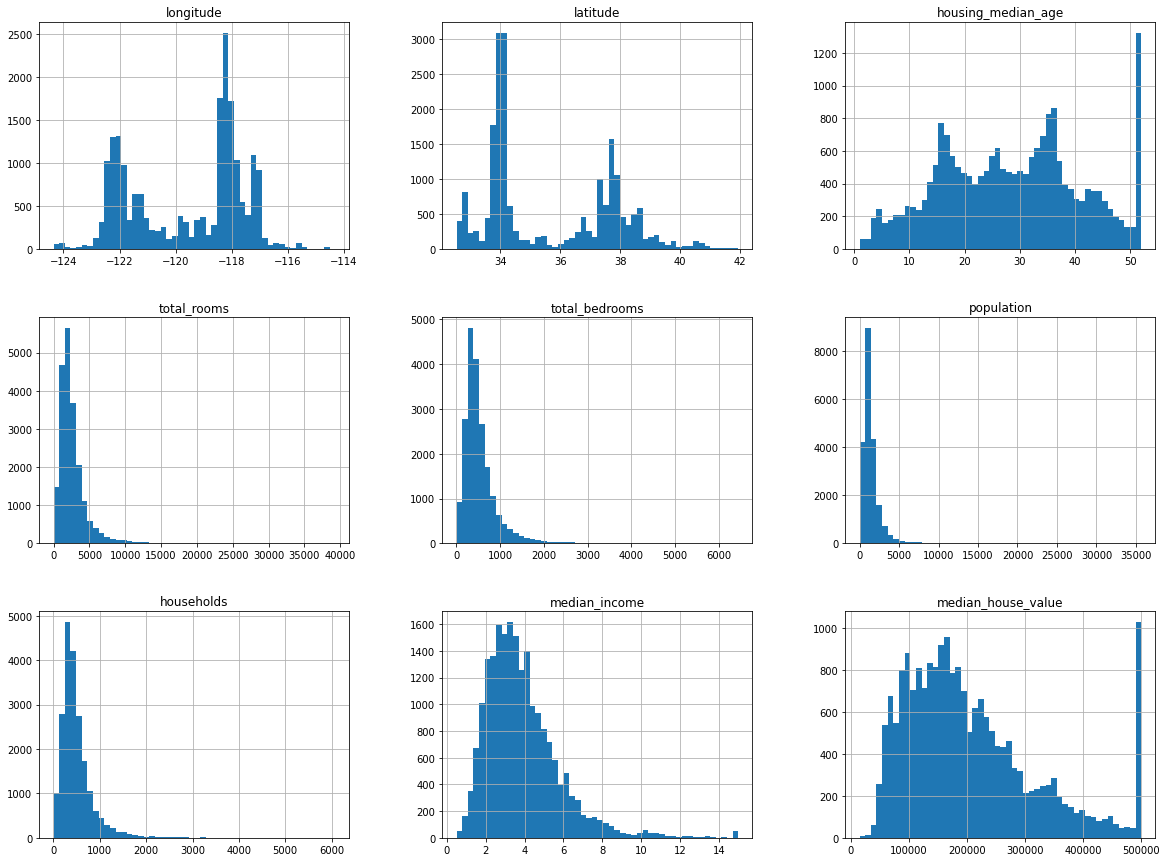

In [9]:
housing.hist(bins = 50,figsize = (20,15))
plt.show()

#Create validation dataset

In [10]:
# Create a random test/validation set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing,test_size = 0.2,random_state = 42)

In [11]:
# Create test/validation set proportional to the median income as it is an important feature
from sklearn.model_selection import StratifiedShuffleSplit

# Split the dataset based on the median_income
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace = True)

# Create test set
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

# Check proportions of different income categories
housing["income_cat"].value_counts()/len(housing)

# Remove income_cat attribute as it is not needed any more
for set_ in (strat_train_set,strat_test_set):
  set_.drop("income_cat",axis = 1,inplace = True)

#Data visualisation

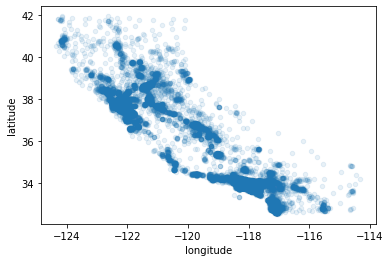

In [12]:
# Geographical plot, darker areas indicate higher density of data
housing.plot(kind = "scatter",x = "longitude", y = "latitude",alpha = 0.1)

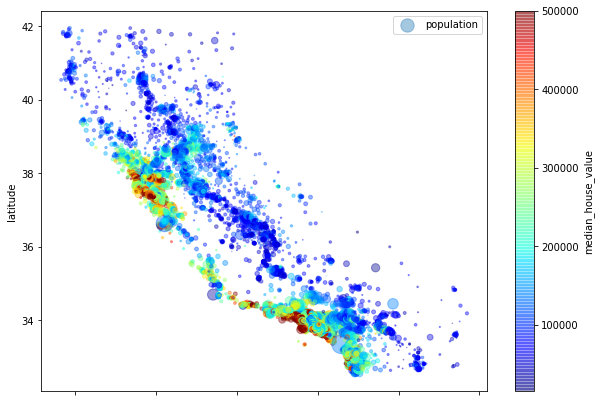

In [13]:
# Geographical color map based on housing prices
# Circle radius indicates population
housing.plot(kind = "scatter",x = "longitude", y = "latitude",alpha = 0.4,
             s = housing["population"]/100,label = "population",figsize=(10,7),
             c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [14]:
# Correlation matrix indicates how much each attribute affects the housing price
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

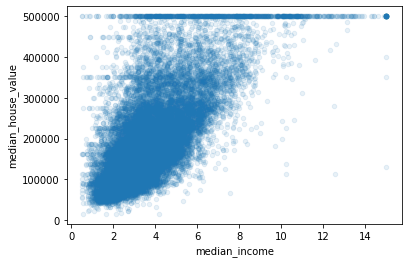

In [15]:
# Median income has the strongest correlation to housing price
housing.plot(kind = "scatter",x = "median_income",y = "median_house_value",alpha = 0.1)

In [16]:
# Separate features from labels
housing = strat_train_set.drop("median_house_value",axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

#Data cleaning and transformation

In [17]:
# Data cleaning and transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin

# Custom transformer to add extra necessary/useful attributes
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,
              bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]
    attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
    housing_extra_attribs = attr_adder.transform(housing.values)

# Custom transformer to feed a pandas dataframe directly into the pipeline instead of np.array
# Converts pandas dataframe to numpy array
class DataFrameSelector(BaseEstimator,TransformerMixin):
  def __init__ (self,attribute_names):
    self.attribute_names = attribute_names
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    return X[self.attribute_names].values

housing_num = housing.drop("ocean_proximity",axis=1)
housing_cat = housing["ocean_proximity"]

num_attributes = list(housing_num)
cat_attributes = ["ocean_proximity"]

# Pipeline for numeric columns
num_pipeline = Pipeline([
        ('selector',DataFrameSelector(num_attributes)),
        ('imputer',SimpleImputer(strategy="median")),
        ('attribs_adder',CombinedAttributesAdder()),
        ('std_scaler',StandardScaler()),
])

# Pipeline for non numeric columns
cat_pipeline = Pipeline([
        ('selector',DataFrameSelector(cat_attributes)),
        ('label_binarizer',OneHotEncoder(sparse=False)),
])

# Pipeline for integrating the above pipelines 
full_pipeline = FeatureUnion(transformer_list = [
        ("num_pipeline",num_pipeline),
        ("cat_pipeline",cat_pipeline),
])

# Dataset after cleaning and transformation is ready to be fed into the model for training
housing_prepared = full_pipeline.fit_transform(housing)
# print(type(housing_prepared))
# housing_prepared.shape

#Try out different models

In [18]:
# Linear regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

model = LinearRegression()
model.fit(housing_prepared,housing_labels)
scores = cross_val_score(model,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
rsme_scores = np.sqrt(-scores)
print(f"The average root mean squared error when using linear regression is {np.mean(rsme_scores)}")

The average root mean squared error when using linear regression is 69052.46136345083


In [19]:
# Decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(housing_prepared,housing_labels)
scores = cross_val_score(tree_model,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
rsme_scores = np.sqrt(-scores)
print(f"The average root mean squared error when using decision tree regressor is {np.mean(rsme_scores)}")

The average root mean squared error when using decision tree regressor is 70726.44203648568


In [20]:
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(verbose=0)
forest_model.fit(housing_prepared,housing_labels)
scores = cross_val_score(forest_model,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
rsme_scores = np.sqrt(-scores)
print(f"The average root mean squared error when using random forest regressor is {np.mean(rsme_scores)}")

The average root mean squared error when using random forest regressor is 50221.18689883525


In [21]:
# Support vector machine regressor
from sklearn.svm import SVR

SVR_model = SVR()
SVR_model.fit(housing_prepared,housing_labels)
scores = cross_val_score(forest_model,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
rsme_scores = np.sqrt(-scores)
print(f"The average root mean squared error when using SVM regressor is {np.mean(rsme_scores)}")

The average root mean squared error when using SVM regressor is 50166.581120384435


#Hyperparameter tuning for random forest model



In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]
grid_search = GridSearchCV(forest_model,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [23]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

#Evaluate the model on test set

In [24]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"The error on the test set is {final_rmse}")

The error on the test set is 47752.325322289216
